# Training an Autonomous Cab to pick up and drop passengers using Q-Learning
Author: <b> Akshitha Pothamshetty </b>
UID: <b>116399326</b>
About: <b>M.Eng Robotics 2020, University of Maryland, College Park</b>

## About Project
<p style='text-align: justify;'>
In this project, I have used Reinforcement Learning to pick up and drop off passengers at the right locations. I have used Q-Learning to train the model. To keep the focus on applying Q-Learning, I have used existing OpenAI GYM environment, Taxi-v3. This task was introduced in [Dietterich2000] to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and our job is to pick up the passenger at one location and drop him off in another. We receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.


In this notebook, I will go through the project step by step.
</p>

### 1: Install and import dependencies
<p style='text-align: justify;'>
Following packages needs to be installed successfully for executing rest of the notebook:
1. CMAKE
2. Scipy
3. Numpy
4. Atari Gym
</p>

In [3]:
!pip install cmake matplotlib scipy numpy 'gym[atari]' # Run only once.

In [6]:
import gym # Import OpenAI GYM package
from IPython.display import clear_output, Markdown, display # For visualization
from time import sleep # For visualization
import random # Randomly generating states
import numpy as np # For Q-Table
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

random.seed(42) # Setting random state for consistent results.


env = gym.make("Taxi-v3").env # Using existing Taxi-V3 environment

# Generate a random environment
env.reset()
env.render()

# Properties of our environment
print("Property: Action Space {}".format(env.action_space))
print("Property: State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Property: Action Space Discrete(6)
Property: State Space Discrete(500)


### 2: Explore our environment
<p style='text-align: justify;'>
Our environment consists of 6 actions:

1. Go South
2. Go North
3. Go East
4. Go West
5. Pick Up Passenger
6. Drop Off a Passenger

Our environment consists of 500 possible states:
* It is a 5x5 grid, with 4 pick up or drop off location, with one additional state of passenger being inside the taxi:

* 5x5 x (4+1) x 4 = 500 states
</p>

In [7]:
# Drop off and pick up locations are indexed from 0-3 for the four 
# different  locations.

# Let's initiate a forced state:
# Taxi at: (3,1), Pick Up at R(0)(Blue) and Drop Off at B(3)(Pink)

initialState = env.encode(3, 1, 0, 3)
print "Out of 500 possible states, our unique state ID is:", initialState

env.s = initialState # set the environment
env.render()

# Let's see the possible action space in this state
print "Action: [Probability, NextState, Reward, GoalReached]"
env.P[initialState]

Out of 500 possible states, our unique state ID is: 323
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action: [Probability, NextState, Reward, GoalReached]


{0: [(1.0, 423, -1, False)],
 1: [(1.0, 223, -1, False)],
 2: [(1.0, 343, -1, False)],
 3: [(1.0, 323, -1, False)],
 4: [(1.0, 323, -10, False)],
 5: [(1.0, 323, -10, False)]}

### 3: Establish a baseline, using Brute Force Approach
<p style='text-align: justify;'>
We will use a Brute force approach to establish a baseline. We will ask the taxi to reach the goal state with no intelligence at all. It will choose a random state to reach the goal. We will evaluate how the model performs from here.
</p>

In [8]:
# Create a visualizer function
def print_frames(frames, episode=1, verbose=False):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        if (verbose):
            print("\nEpisode Number {}".format(episode))
        print("Timestep: {}".format(i + 1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)

def printmd(string):
    display(Markdown(string))

In [12]:
env.s = initialState  # Set environment to initial state.

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1

# Start visualization only if steps taken are less than 1000. Otherwise it takes too long.
if epochs < 1000:
    print_frames(frames)

print("\nSteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 508
State: 475
Action: 5
Reward: 20

Steps taken: 508
Penalties incurred: 163


### 4: Train the model using Reinforcement Learning
<p style='text-align: justify;'>
Using a Q-Learning approach to train the model. Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state. For this purpose, we will create a Q-table to store Q-values, that map to a state and corresponding action combination. A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Better Q-values imply better chances of getting greater rewards.

For evaluation of the model, We will keep a track of how many timesteps and number of penalties incurred while training the model.
</p>

In [14]:
%%time

# initialize a q-table to store q-values for each state-action pair.
q_table = np.zeros([env.observation_space.n, env.action_space.n]) # Initialize a q-table with zeros

print"Training the agent .. .. .." # Typically takes around 3m 17seconds around

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 1.0
min_epsilon = 0.1
max_epsilon = 1.00

# For plotting metrics
all_epochs = []
all_penalties = []
all_epsilons = []

frames = [] # for animation
rewards = [] # for analyzing training.

for episode in range(1, 100001):
    state = env.reset()
    episode_rewards = []

    epochs, penalties, reward = 0, 0, 0
    done = False
    
    while not done:
        # Explore Action Space
        if random.uniform(0, 1) < min_epsilon:
            action = env.action_space.sample()
        # Exploit learned Values
        else:
            action = np.argmax(q_table[state])

        # Get next state, reward, goal_status
        next_state, reward, done, info = env.step(action)
        
        # current q-value
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # Learning: update current q-value based on best chosen next step
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        if done:
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-0.0001*episode)
            all_epsilons.append(epsilon)
        # check if penalties incurred
        if reward == -10:
            penalties += 1
        
        episode_rewards.append(reward)

        # update state
        state = next_state
        epochs += 1
        
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
    
    rewards.append(np.mean(episode_rewards))
    # render training progress
    if episode % 100 == 0:
        clear_output(wait=True)
        print("Training ongoing...\nSuccessfully completed {} Pick-Drop episodes.".format(episode))

print("Training finished.\n")

Training ongoing...
Successfully completed 100000 Pick-Drop episodes.
Training finished.

CPU times: user 3min 23s, sys: 3.25 s, total: 3min 26s
Wall time: 3min 25s


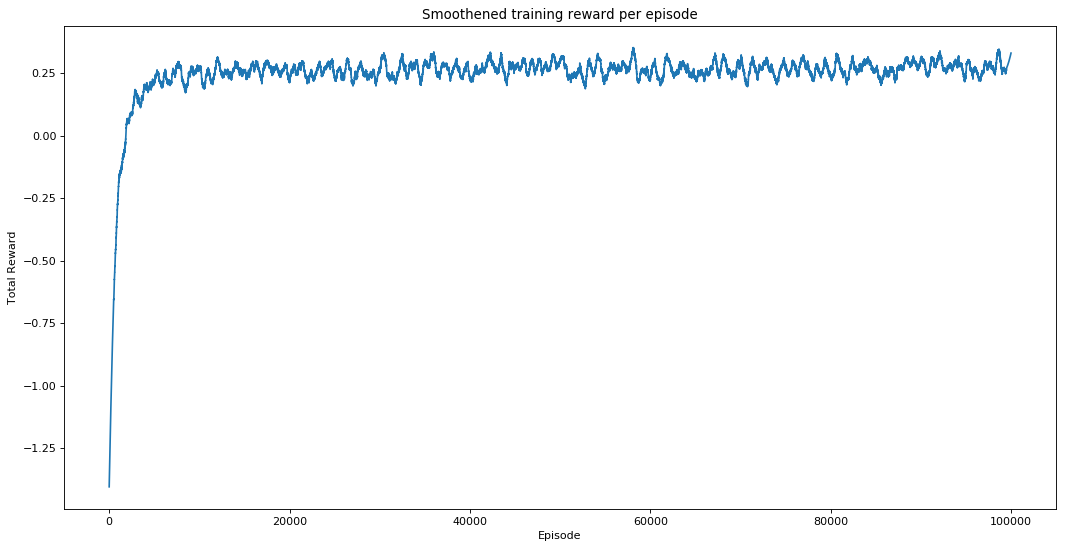

In [49]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(savgol_filter(rewards, 1001, 2))
plt.title("Smoothened training reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

As we can see, rewards are getting more and more positive as the training continues and starts to converge once the model is trained. Depending on the graph, 25,000 epochs seem enough to train the agent successfully.

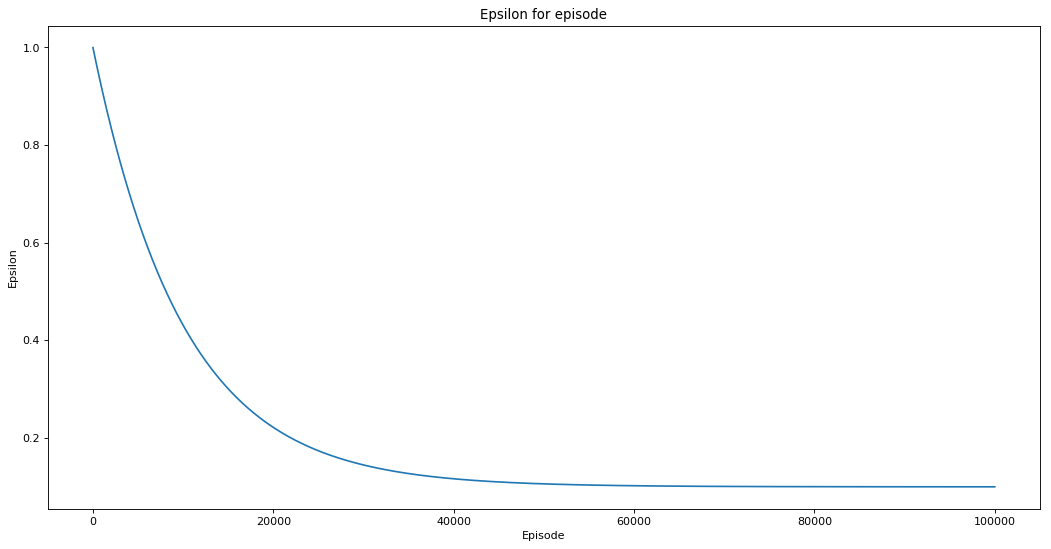

In [68]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(all_epsilons)
plt.title("Epsilon for episode")
plt.xlabel('Episode');
plt.ylabel('Epsilon');

<p style='text-align: justify;'>
Epsilon is the exploration factor. It shuffles the model from exploration mode to exploitation mode. Exploration is finding new information about the environment. Whereas, Exploitation using existing information to maximize the reward. Initially, our driving agent knows pretty much nothing about the best set of driving directions for picking up and dropping off passengers. After good amount of exploration, we want our agent to switch to exploitation mode. Eventually, all choices will be based on what is learned.
    
In this graph, we can see how it decreases over training. Lower values of epsilon switches the agent to exploitation model. This is a desired trend.
</p>

### 5: Analyze what the model has learned

We want to see if the model has learned to take optimum steps from any state to reach a goal position.

In [5]:
import pprint
# Drop off and pick up locations are indexed from 0-3 for the four 
# different  locations.

# Let's initiate first forced state:
# Taxi at: (2,0), Passenger inside the taxi and Drop Off at R(0)(Pink)

statesList = [[2,0,4,0], [2,0,4,2], [2,3,4,3], [2,3,4,1]]
Actions = ["South", "North", "East", "West", "PickUp", "DropOff"]
exampleCount = 0

for state in statesList:
    exampleCount += 1
    exampleState = env.encode(*state)
    print"Example {}: Passenger inside taxi - To be dropped at location: {}".format(exampleCount, state[3])
    env.s = exampleState # set the environment
    env.render()

    # Let's see the possible action space in this state
    env.P[exampleState]
    
    stateAction = dict(zip(Actions, q_table[exampleState]))
    max_key = max(stateAction, key=stateAction.get)
    print "Best Action:", max_key, "\nQ-Value:",round(stateAction[max_key], 2)

    print "\n--------------------------------------------------------\n"

Example 1: Passenger inside taxi - To be dropped at location: 0
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Best Action: North 
Q-Value: 5.6

--------------------------------------------------------

Example 2: Passenger inside taxi - To be dropped at location: 2
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Best Action: South 
Q-Value: 5.6

--------------------------------------------------------

Example 3: Passenger inside taxi - To be dropped at location: 3
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Best Action: South 
Q-Value: 5.6

--------------------------------------------------------

Example 4: Passenger inside taxi - To be dropped at location: 1
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Best Action: North 
Q-Value: 2.36

-------------------------------------------------

<p style='text-align: justify;'>
As we can see after the training has been completed, the cab agent is able to predict the best step to reach destination accurately.

1. In example 1, cab with the passenger is at (2,0). Dropping destination for the case is R(0). The most sensible step is to move north. The model predicts this accurately as:

| Best Action | || | Q-Value
| --- | ---| --- |
| North | || | 5.6 |

2. In example 3, cab with the passenger is at (2,3). Dropping destination for the case is B(3). The most sensible step is to move South. The model predicts this accurately as:

| Best Action | || | Q-Value
| --- | ---| --- |
| South | || | 5.6 |

3. Similarly, in example 4, can is at (2,3) with the passenger inside. The dropping destination for the case is G(1). Both North and East have same q-values in this case, 2.36. Thus, the model hasn't overfit and predicts both the correct paths successfully. 
</p>

### 6: Evaluating agent's performance after training.

<p style='text-align: justify;'>
Now we want to test our model on finding best routes between checkpoints and analyze penalties it is adding, if any!
</p>

In [15]:
total_epochs, total_penalties = 0, 0
episodes = 100 # Give 100 tests to the agent.
# frames = [] # for animation
testRewards = [] # Analyzing performance

sleep(5)

for episode in range(episodes):
    state = env.reset() # Reset the environment to a random new state
    epochs, penalties, reward = 0, 0, 0
    
    done = False # Episode completed?
    frames = []
    episodeRewards = []
    while not done: # While not dropped at correct destination
        action = np.argmax(q_table[state]) # Choose best action for a given state
        state, reward, done, info = env.step(action) # Get reward, new state and drop status

        if reward == -10: # Increment penalties if occurred
            penalties += 1

        epochs += 1 # Keep track of timesteps required to successfully reach the destination.

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        episodeRewards.append(reward)
    total_penalties += penalties
    total_epochs += epochs
    testRewards.append(np.mean(episodeRewards))
    
    # Visualize the current episode.
    print_frames(frames, episode+1, True)
    sleep(.50)
    
print"\n----------------- Test Results --------------------- \n"
print("Results after {} episodes:".format(episodes))
print("Average timesteps per episode: {}".format(total_epochs / episodes))
print("Average penalties per episode: {}".format(total_penalties / episodes))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


Episode Number 100
Timestep: 11
State: 85
Action: 5
Reward: 20

----------------- Test Results --------------------- 

Results after 100 episodes:
Average timesteps per episode: 13
Average penalties per episode: 0


### Test Results

<p style='text-align: justify;'>

* We can see from the evaluation, the agent's performance improved significantly and it incurred no penalties, which means it performed the correct pickup/dropoff actions with 100 different passengers.

* Timesteps taken to reach destination has also reduced significantly, around 12 for each trip, which is what we would expect from a trained driver.

* Thus, we see that cab agent learns to navigate in the grid city smoothly without incurring any penalties.
</p>